# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks. This is our first introductory class, with the initial goal of level setting and kicking-off discussions on training neural networks.

Please complete all challenges below for 10 (+ 2 extra) points in total. 

In [1]:
import torch
import torchvision
import matplotlib.pyplot as pl
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [2]:
batch_size_train = 64
batch_size_test = 1000

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

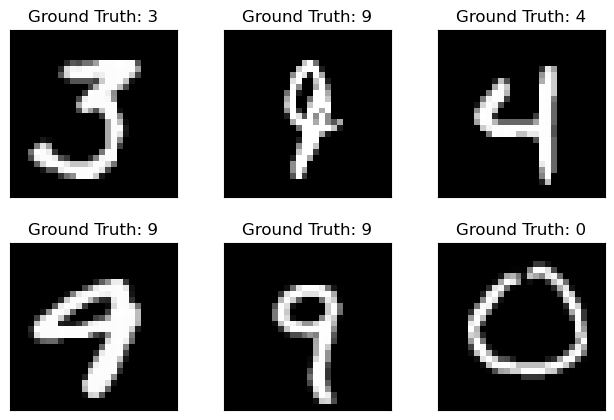

In [5]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [8]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [9]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [10]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
! mkdir -p results

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [13]:
train(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653


/tmp/ipykernel_2028/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784095
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237687
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.040590
Train Epoch: 1 [13440/60

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [14]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [15]:
test()

/tmp/ipykernel_2028/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/opt/conda/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [16]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541078


/tmp/ipykernel_2028/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488056
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586396
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554513
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585009
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.734861
Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.680402
Train Epoch: 2 [14080

# Model performance

Finally, we can inspect the results.

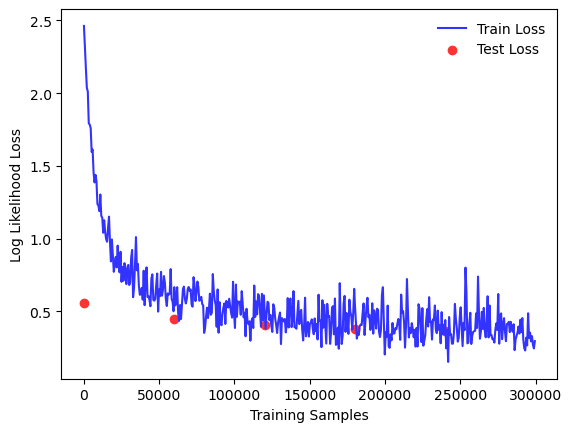

In [17]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [18]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

/tmp/ipykernel_2028/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge: (2pt)** Can you explain why we are using `torch.no_grad()`?

**Answer:** Using `torch.no_grad()` prevents the calculation of gradients, which improves the performance of machine learning models by decreasing the computation work and memory needed.`torch.nograd()` is especially useful for feed forward neural networks, where model weights do not need to be updated, speeding up the overall training process.

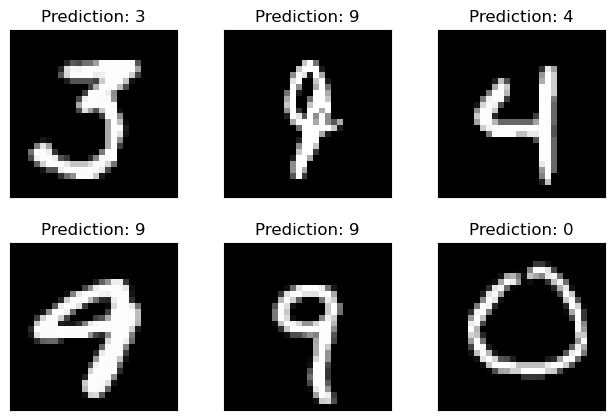

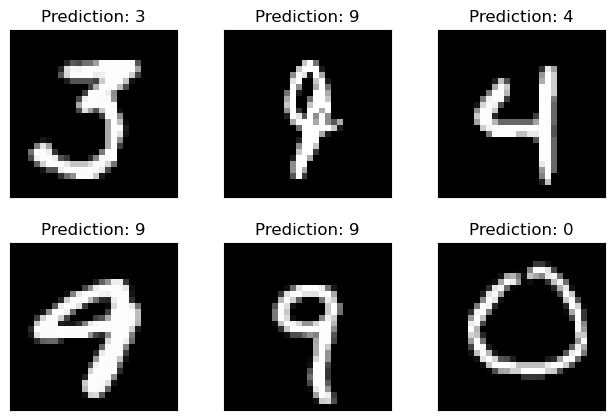

In [19]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Challenge: (1pt)** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

**Answer:** Challenge completed in the code below:

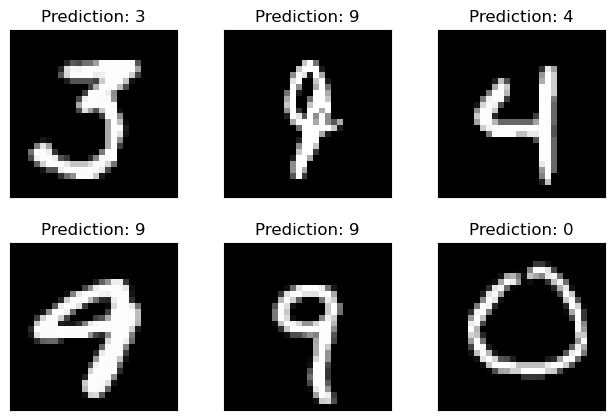

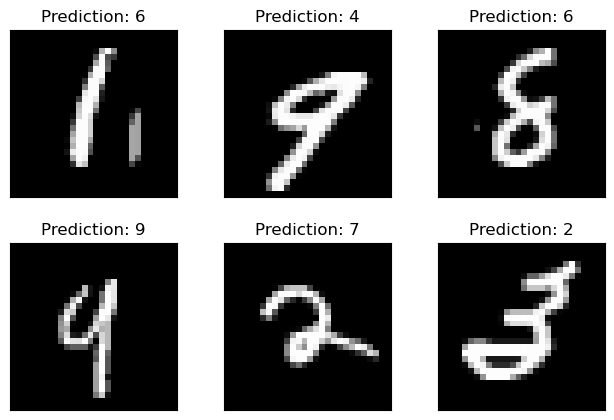

In [20]:
# Find incorrect predictions
inc_example_data = []
inc_outputs = []
idx = 6
while idx < len(example_data) and len(inc_example_data) < 6:
    predicted = output.data.max(1, keepdim=True)[1][idx].item()
    if (predicted != example_targets[idx]):
        inc_example_data.append(example_data[idx])
        inc_outputs.append(predicted)
    idx += 1

# Plot incorrect example data
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(inc_example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(inc_outputs[i]))
    pl.xticks([])
    pl.yticks([])
fig

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [21]:
! ls results

model_iteration-1.pth  model_iteration-5.pth	  optimizer_iteration-4.pth
model_iteration-2.pth  optimizer_iteration-1.pth  optimizer_iteration-5.pth
model_iteration-3.pth  optimizer_iteration-2.pth
model_iteration-4.pth  optimizer_iteration-3.pth


To load a model:

In [22]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [23]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [24]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

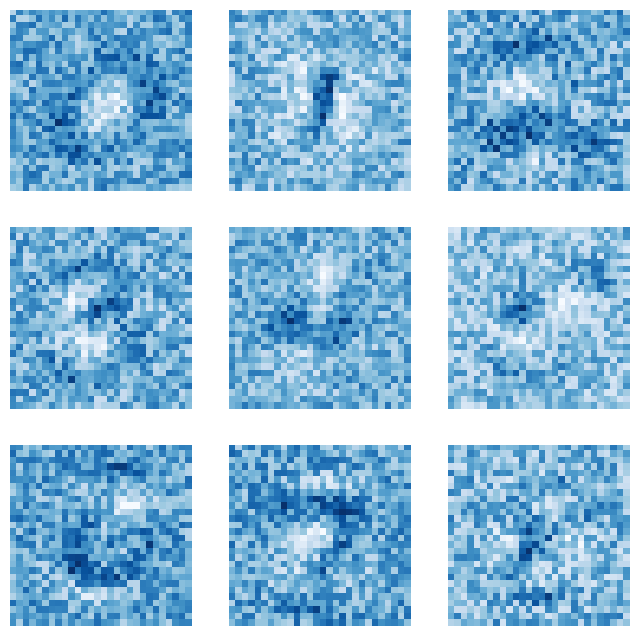

In [25]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [26]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

In [27]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

**Challenge (1pt):** Can you explain the data in this dictionary?

**Answer**: State `0` represents the images where portions are identified in blue and white. State `1` represents the bias terms associated with each image present in the dictionary. The `param_groups` describe the parameters used during model training, such as learning rate (`lr`), momentum, and more.

## Final challenges

* **(1 pt)** What happens if you use only 10% of the available training data? Plot the difference in performance of the network.
* **(0.5pt)** What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?
* **(0.5pt)** What happens if you change parameters like the learnign rate and momentum? Plot the difference.
* **(2pt)** Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?
* **(2pt)** Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?
* **[stretch] (2pt)** Can you change this model and turn it into a convolutional neural network?

* **(1 pt)** What happens if you use only 10% of the available training data? Plot the difference in performance of the network.

In [28]:
def train_mod(epoch, trainer, train_losses, train_counter, network, optimizer):
    network.train()
    for batch_idx, (data, target) in enumerate(trainer):
        optimizer.zero_grad()
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainer.dataset),
                100. * batch_idx / len(trainer), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(trainer.dataset)))

def test_mod(test_losses, network):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [29]:
train_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                           ]))
train_10 = torch.utils.data.Subset(train_dataset, list(range(int(0.1 * len(train_dataset)))))
train_loader_10 = torch.utils.data.DataLoader(train_10, batch_size=batch_size_train, shuffle=True)

network_10 = FeedforwardNeuralNetModel()
optimizer_10 = optim.SGD(network_10.parameters(), lr=learning_rate, momentum=momentum)
n_epochs = 5

train_losses_10 = []
train_counter_10 = []
test_losses_10 = []
test_counter_10 = [i*len(train_loader_10.dataset) for i in range(n_epochs + 1)]
    
# Training
for epoch in range(1, n_epochs + 1):
    train_mod(epoch, train_loader_10, train_losses_10, train_counter_10, network_10, optimizer_10)
    test_mod(test_losses_10, network_10)

/tmp/ipykernel_2028/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.387693
Train Epoch: 1 [640/6000 (11%)]	Loss: 2.262907
Train Epoch: 1 [1280/6000 (21%)]	Loss: 2.063718
Train Epoch: 1 [1920/6000 (32%)]	Loss: 2.023602
Train Epoch: 1 [2560/6000 (43%)]	Loss: 1.905690
Train Epoch: 1 [3200/6000 (53%)]	Loss: 1.801595
Train Epoch: 1 [3840/6000 (64%)]	Loss: 1.759712
Train Epoch: 1 [4480/6000 (74%)]	Loss: 1.592667
Train Epoch: 1 [5120/6000 (85%)]	Loss: 1.500170
Train Epoch: 1 [5760/6000 (96%)]	Loss: 1.495899

Test set: Avg. loss: 1.4904, Accuracy: 6412/10000 (64%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 1.460441
Train Epoch: 2 [640/6000 (11%)]	Loss: 1.421678
Train Epoch: 2 [1280/6000 (21%)]	Loss: 1.285988
Train Epoch: 2 [1920/6000 (32%)]	Loss: 1.259769
Train Epoch: 2 [2560/6000 (43%)]	Loss: 1.367833
Train Epoch: 2 [3200/6000 (53%)]	Loss: 1.382225
Train Epoch: 2 [3840/6000 (64%)]	Loss: 1.280855
Train Epoch: 2 [4480/6000 (74%)]	Loss: 1.273919
Train Epoch: 2 [5120/6000 (85%)]	Loss: 1.282933
Train Epoch: 2 [5760/6000 (96%)]	Loss: 1

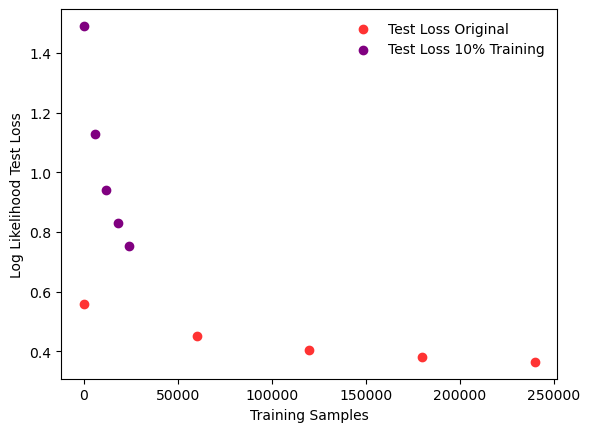

In [30]:
fig = pl.figure()
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))
pl.scatter(test_counter_10[:-1], test_losses_10, color='purple')

pl.legend(['Test Loss Original', 'Test Loss 10% Training'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Test Loss')

pl.show()

**Answer:** Using 10% of the available training data results in similar training performance and a higher testing set loss. As seen in the graph above, test set losses were higher for each epoch when trianed on 10 percent training data in comparison to the full dataset.

* **(0.5pt)** What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?


In [31]:
five_idx = [i for i in range(len(train_loader.dataset)) if train_loader.dataset[i][1] == 5]
all_idx = [i for i in range(len(train_loader.dataset))]
to_remove = five_idx[:int(len(five_idx) * 0.8)]

train_20 = torch.utils.data.Subset(train_dataset, list(set(all_idx) - set(to_remove)))
train_20_loader = torch.utils.data.DataLoader(train_20, batch_size=batch_size_train, shuffle=True)

n_epochs = 5
train_losses_20 = []
train_counter_20 = []
test_losses_20 = []
test_counter_20 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

network_20 = FeedforwardNeuralNetModel()
optimizer_20 = optim.SGD(network_20.parameters(), lr=learning_rate, momentum=momentum)

for i in range(1,n_epochs+1):
    train_mod(i, train_20_loader, train_losses, train_counter, network_20, optimizer_20)
    test_mod(test_losses_20, network_20)

/tmp/ipykernel_2028/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/55664 (0%)]	Loss: 2.664907
Train Epoch: 1 [640/55664 (1%)]	Loss: 2.449152
Train Epoch: 1 [1280/55664 (2%)]	Loss: 2.194446
Train Epoch: 1 [1920/55664 (3%)]	Loss: 2.020185
Train Epoch: 1 [2560/55664 (5%)]	Loss: 2.009456
Train Epoch: 1 [3200/55664 (6%)]	Loss: 1.912318
Train Epoch: 1 [3840/55664 (7%)]	Loss: 1.715003
Train Epoch: 1 [4480/55664 (8%)]	Loss: 1.600183
Train Epoch: 1 [5120/55664 (9%)]	Loss: 1.517580
Train Epoch: 1 [5760/55664 (10%)]	Loss: 1.617459
Train Epoch: 1 [6400/55664 (11%)]	Loss: 1.476228
Train Epoch: 1 [7040/55664 (13%)]	Loss: 1.283693
Train Epoch: 1 [7680/55664 (14%)]	Loss: 1.364118
Train Epoch: 1 [8320/55664 (15%)]	Loss: 1.317314
Train Epoch: 1 [8960/55664 (16%)]	Loss: 1.290706
Train Epoch: 1 [9600/55664 (17%)]	Loss: 1.237881
Train Epoch: 1 [10240/55664 (18%)]	Loss: 1.056343
Train Epoch: 1 [10880/55664 (20%)]	Loss: 1.070225
Train Epoch: 1 [11520/55664 (21%)]	Loss: 1.169893
Train Epoch: 1 [12160/55664 (22%)]	Loss: 1.074594
Train Epoch: 1 [12800/55664 (

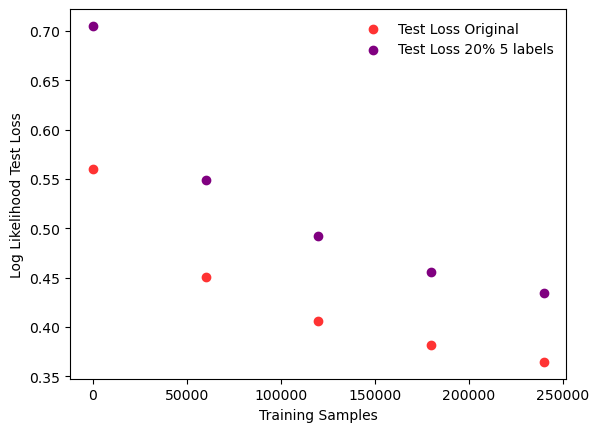

In [32]:
fig = pl.figure()
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))
pl.scatter(test_counter_20[:-1], test_losses_20, color='purple')

pl.legend(['Test Loss Original', 'Test Loss 20% 5 labels'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Test Loss')

pl.show()

Looking at the plot above, we can see that the test loss increase for each iteration when 80 percent of all training data labeled "5" is taken out of the training set. Furthermore, the trend of each training sets scatterplot seems to follow a general pattern, which gives us reason to believe that there could be a homogeneous difference.

* **(0.5pt)** What happens if you change parameters like the learnign rate and momentum? Plot the difference.


/tmp/ipykernel_2028/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.506094
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.291960
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.056195
Train Epoch: 1 [1920/60000 (3%)]	Loss: 9.372700
Train Epoch: 1 [2560/60000 (4%)]	Loss: 8.768620
Train Epoch: 1 [3200/60000 (5%)]	Loss: 8.155530
Train Epoch: 1 [3840/60000 (6%)]	Loss: 7.507080
Train Epoch: 1 [4480/60000 (7%)]	Loss: 5.189506
Train Epoch: 1 [5120/60000 (9%)]	Loss: 4.642100
Train Epoch: 1 [5760/60000 (10%)]	Loss: 7.275208
Train Epoch: 1 [6400/60000 (11%)]	Loss: 12.759078
Train Epoch: 1 [7040/60000 (12%)]	Loss: 14.771979
Train Epoch: 1 [7680/60000 (13%)]	Loss: 19.107107
Train Epoch: 1 [8320/60000 (14%)]	Loss: 14.255562
Train Epoch: 1 [8960/60000 (15%)]	Loss: 6.757637
Train Epoch: 1 [9600/60000 (16%)]	Loss: 14.398180
Train Epoch: 1 [10240/60000 (17%)]	Loss: 20.701595
Train Epoch: 1 [10880/60000 (18%)]	Loss: 29.132286
Train Epoch: 1 [11520/60000 (19%)]	Loss: 4.967228
Train Epoch: 1 [12160/60000 (20%)]	Loss: 5.456218
Train Epoch: 1 [12800/

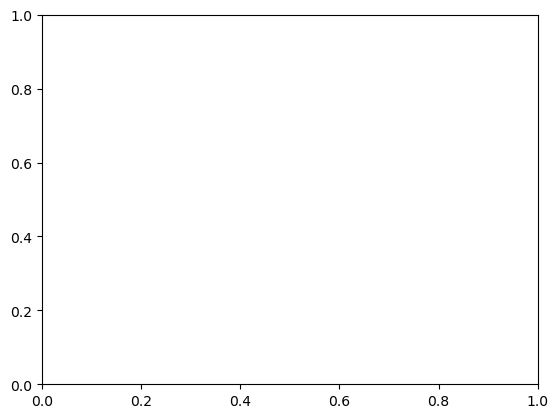

In [33]:
lrs = [0.1, 0.01, 0.001]
momentums = [1, 0.5, 0.001]
colors = ['red', 'blue', 'green']
fig, ax = pl.subplots()
results = []
for lr, momentum in zip(lrs, momentums):
    network = FeedforwardNeuralNetModel()
    optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)
    n_epochs = 5
    
    train_losses_temp = []
    train_counter_temp = []
    test_losses_temp = []
    test_counter_temp = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    
    for j in range(1,n_epochs+1):
        train_mod(j, train_loader, train_losses_temp, train_counter_temp, network, optimizer)
        test_mod(test_losses_temp, network)
        
    results.append(test_losses_temp)
        
    

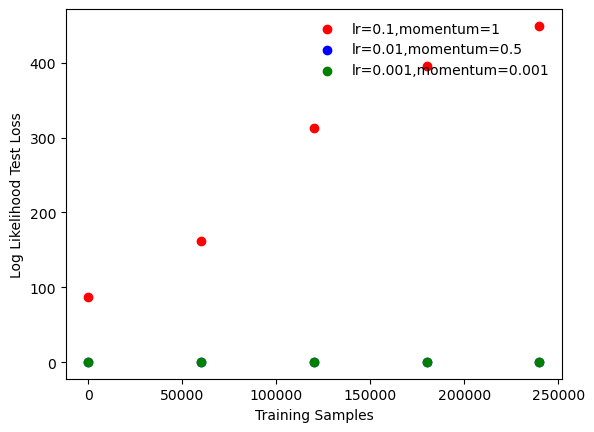

In [41]:
fig = pl.figure()
pl.scatter(test_counter[:-1], results[0], color=colors[0])
pl.scatter(test_counter[:-1], results[1], color=colors[1])
pl.scatter(test_counter[:-1], results[2], color=colors[2])

pl.legend([f"lr={lrs[0]},momentum={momentums[0]}", f"lr={lrs[1]},momentum={momentums[1]}", f"lr={lrs[2]},momentum={momentums[2]}"], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Test Loss')

pl.show()

Increasing the momentum results in an increase of test loss, and a similar effect can be observed with the learning rate. As learning rate determines how high a step is taken during gradient descent, large learning rate values can result in failure to converge to the optimal value. Too high of a momentum value can cause failure in converegence as well as it determine how fast convergence occurs, and large values can result in inconsistent results.

* **(2pt)** Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?


In [42]:
class FeedforwardNeuralNetModel2(nn.Module):
    def __init__(self):
        super(FeedforwardNeuralNetModel2, self).__init__()
        input_dim = 28 * 28
        hidden_dim1 = 512  
        hidden_dim2 = 256
        out_dim = 10 

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.out = nn.Linear(hidden_dim2, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.out(x)
        return F.log_softmax(out)


network_hid = FeedforwardNeuralNetModel2()
optimizer_hid = optim.SGD(network_hid.parameters(), lr=learning_rate, momentum=momentum)
n_epochs = 10

train_losses_hid = []
train_counter_hid = []
test_losses_hid = []
test_counter_hid = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

network = FeedforwardNeuralNetModel2()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) 

for i in range(1,n_epochs+1):
    train_mod(i, train_loader, train_losses_hid, train_counter_hid, network_hid, optimizer_hid)
    test_mod(test_losses_hid, network_hid)
    train_mod(i, train_loader, train_losses, train_counter, network, optimizer)
    test_mod(test_losses, network)

/tmp/ipykernel_2028/3315526085.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304926
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.308479
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.320976
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.301512
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.296042
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.293861
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.288675
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.276307
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.285168
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.278406
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.282599
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.270062
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.269129
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.259020
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.248138
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.258434
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.249623
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.237938
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.252829
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.243641
Train Epoch: 1 [12800/60000 (

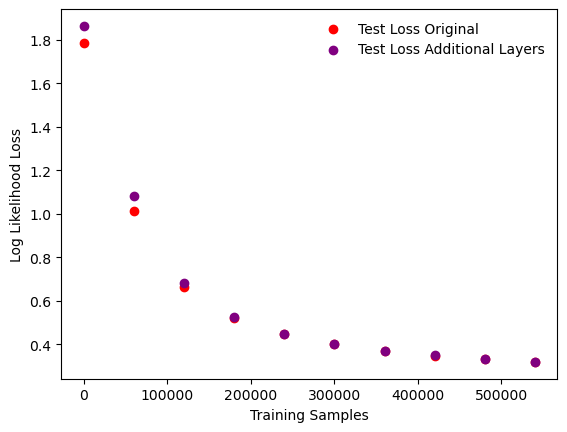

In [43]:
fig = pl.figure()
pl.scatter(test_counter[:-1], test_losses, color="red")
pl.scatter(test_counter_hid[:-1], test_losses_hid, color="purple")

pl.legend(['Test Loss Original', 'Test Loss Additional Layers'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

**Answer:** Yes, I was able to add more layers to the neural network, consisting of one input layer, three hidden layers, and one output layer. Adding these additional layers initally resulted in a rise in test loss for the first training sample, and later continued to either beat or match the test loss of the original training model. 

* **(2pt)** Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?


In [44]:
def l1_regularization(model, l1_lambda):
    l1_norm = sum(param.abs().sum() for param in model.parameters())
    return l1_lambda * l1_norm

network_l1 = FeedforwardNeuralNetModel2()
optimizer_l1 = optim.SGD(network_l1.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 10
log_interval = 10
l1_lambda = 0.001 

train_losses_l1 = []
train_counter_l1 = []
test_losses_l1 = []
test_counter_l1 = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train_l1(epoch):
    network_l1.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network_l1(data.reshape(-1, 28*28))

        loss = F.nll_loss(output, target)

        l1_loss = l1_regularization(network_l1, l1_lambda)
        total_loss = loss + l1_loss

        total_loss.backward()  
        optimizer_l1.step()  

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss.item())
            )
            train_losses_l1.append(total_loss.item())
            train_counter_l1.append((batch_idx * len(data)) + ((epoch - 1) * len(train_loader.dataset)))


network = FeedforwardNeuralNetModel2()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

n_epochs = 10
for i in range(1, n_epochs + 1):
    train_l1(i)
    test_mod(test_losses_l1, network_l1)
    train_mod(i, train_loader, train_losses, train_counter, network, optimizer)
    test_mod(test_losses, network)

/tmp/ipykernel_2028/3315526085.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 12.452798
Train Epoch: 1 [640/60000 (1%)]	Loss: 12.401698
Train Epoch: 1 [1280/60000 (2%)]	Loss: 12.266423
Train Epoch: 1 [1920/60000 (3%)]	Loss: 12.033326
Train Epoch: 1 [2560/60000 (4%)]	Loss: 11.743150
Train Epoch: 1 [3200/60000 (5%)]	Loss: 11.352547
Train Epoch: 1 [3840/60000 (6%)]	Loss: 10.825069
Train Epoch: 1 [4480/60000 (7%)]	Loss: 10.346088
Train Epoch: 1 [5120/60000 (9%)]	Loss: 9.559658
Train Epoch: 1 [5760/60000 (10%)]	Loss: 9.183216
Train Epoch: 1 [6400/60000 (11%)]	Loss: 8.630901
Train Epoch: 1 [7040/60000 (12%)]	Loss: 8.321052
Train Epoch: 1 [7680/60000 (13%)]	Loss: 7.830571
Train Epoch: 1 [8320/60000 (14%)]	Loss: 7.930326
Train Epoch: 1 [8960/60000 (15%)]	Loss: 7.244879
Train Epoch: 1 [9600/60000 (16%)]	Loss: 7.010852
Train Epoch: 1 [10240/60000 (17%)]	Loss: 6.603542
Train Epoch: 1 [10880/60000 (18%)]	Loss: 7.703321
Train Epoch: 1 [11520/60000 (19%)]	Loss: 6.194124
Train Epoch: 1 [12160/60000 (20%)]	Loss: 5.838467
Train Epoch: 1 [12800

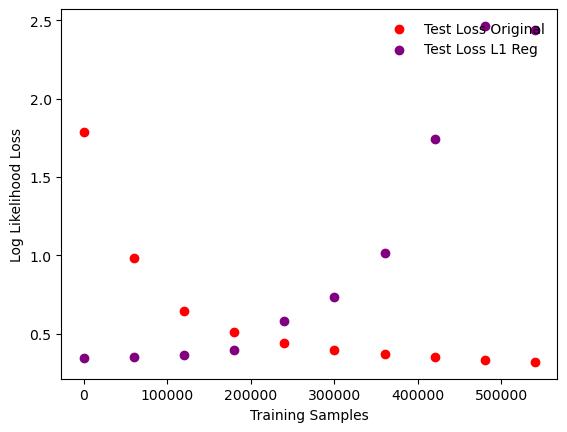

In [45]:
fig = pl.figure()
pl.scatter(test_counter[:-1], test_losses, color="red")
pl.scatter(test_counter_l1[:-1], test_losses_l1, color="purple")

pl.legend(['Test Loss Original', 'Test Loss L1 Reg'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

After implementing L1 regularization in the neural network designed in the previous question, we can observe that the test loss is higher for each sample in comparison to the original model. Further optimization is required (such as searching for the best learning rate and momentum) in order to get better performance.

In [46]:
network_l2 = FeedforwardNeuralNetModel2()
l2_lambda = 0.001

optimizer_l2 = optim.SGD(network_l2.parameters(), lr=learning_rate, momentum=momentum, weight_decay=l2_lambda)

n_epochs = 10

train_losses_l2 = []
train_counter_l2 = []
test_losses_l2 = []
test_counter_l2 = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

network = FeedforwardNeuralNetModel2()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

for i in range(1, n_epochs + 1):
    train_mod(i, train_loader, train_losses_l2, train_counter_l2, network_l2, optimizer_l2)
    test_mod(test_losses_l2, network_l2)

    train_mod(i, train_loader, train_losses, train_counter, network, optimizer)
    test_mod(test_losses, network)

/tmp/ipykernel_2028/3315526085.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315161
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.339384
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.305856
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.301214
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.319572
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.295753
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.319730
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.278643
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.295368
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.284471
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.255361
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.299494
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.267633
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.274367
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.258057
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.266922
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.271418
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.263377
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.267416
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.277957
Train Epoch: 1 [12800/60000 (

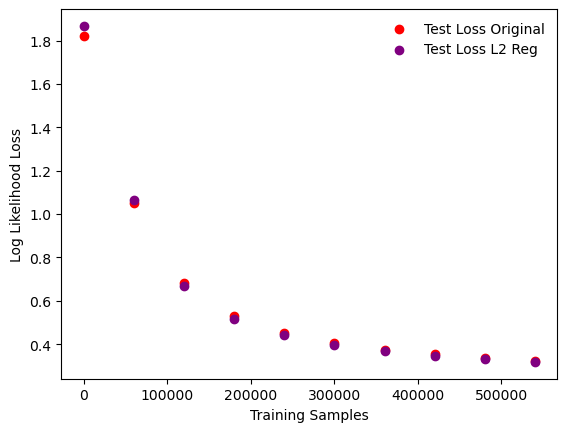

In [47]:
fig = pl.figure()
pl.scatter(test_counter[:-1], test_losses, color="red")
pl.scatter(test_counter_l2[:-1], test_losses_l2, color="purple")

pl.legend(['Test Loss Original', 'Test Loss L2 Reg'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

**Mention how L2 performed**

In [48]:
class FeedforwardNeuralNetModel3(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(FeedforwardNeuralNetModel3, self).__init__()
        input_dim = 28 * 28
        hidden_dim1 = 512  
        hidden_dim2 = 256
        out_dim = 10 

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.out = nn.Linear(hidden_dim2, out_dim)

        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        out = self.out(x)
        return F.log_softmax(out, dim=1)

network_drop = FeedforwardNeuralNetModel3(dropout_prob=0.5)
optimizer_drop = optim.SGD(network_drop.parameters(), lr=learning_rate, momentum=momentum)
n_epochs = 10

train_losses_drop = []
train_counter_drop = []
test_losses_drop = []
test_counter_drop = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

network = FeedforwardNeuralNetModel3(dropout_prob=0.0)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

for i in range(1, n_epochs + 1):
    train_mod(i, train_loader, train_losses_drop, train_counter_drop, network_drop, optimizer_drop)
    test_mod(test_losses_drop, network_drop)

    train_mod(i, train_loader, train_losses, train_counter, network, optimizer)
    test_mod(test_losses, network)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337912
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.327811
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.280138
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.309352
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.302888
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.261514
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.269764
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.284493
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.205631
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.309211
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.280767
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.236347
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.285514
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.326353
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.313777
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.257152
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.243624
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.239645
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.276294
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.230550
Train Epoch: 1 [12800/60000 (

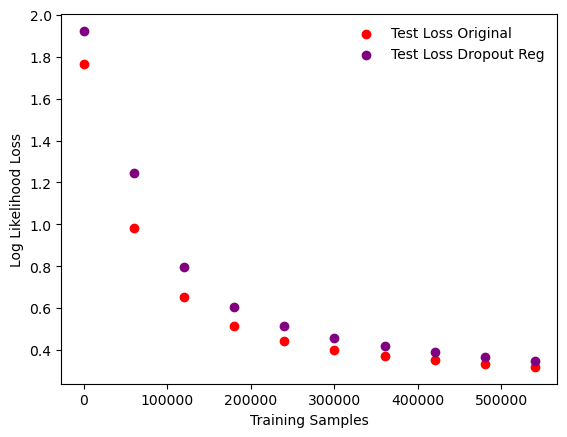

In [49]:
fig = pl.figure()
pl.scatter(test_counter[:-1], test_losses, color="red")
pl.scatter(test_counter_drop[:-1], test_losses_drop, color="purple")

pl.legend(['Test Loss Original', 'Test Loss Dropout Reg'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

**Mention how Dropout reg performed**

* **[stretch] (2pt)** Can you change this model and turn it into a convolutional neural network?

In [60]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        num_classes = 100  
        num_classes2 = 10
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=2)  
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2) 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2)          
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 2 * 2, num_classes)
        self.out = nn.Linear(num_classes, num_classes2)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        
        x = self.conv1(x) 
        x = self.conv2(x) 
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        out = self.out(x)
        
        return F.log_softmax(out, dim=1)

In [61]:
network = CNN()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

network_cnn = CNN()
optimizer_cnn = optim.SGD(network_cnn.parameters(), lr=learning_rate, momentum=momentum)

train_losses_cnn = []
train_counter_cnn = []
test_losses_cnn = []
test_counter_cnn = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]


n_epochs = 10

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

for i in range(1, n_epochs + 1):
    train_mod(i, train_loader, train_losses_cnn, train_counter_cnn, network_cnn, optimizer_cnn)
    test_mod(test_losses_cnn, network_cnn)

    train_mod(i, train_loader, train_losses, train_counter, network, optimizer)
    test_mod(test_losses, network)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294961
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.294607
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.302995
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.293582
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.293346
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.296078
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.292063
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.287154
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.285135
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.282230
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.282719
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.290723
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.304652
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.297088
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.293690
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.289176
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.285077
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.283510
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.280779
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.274991
Train Epoch: 1 [12800/60000 (

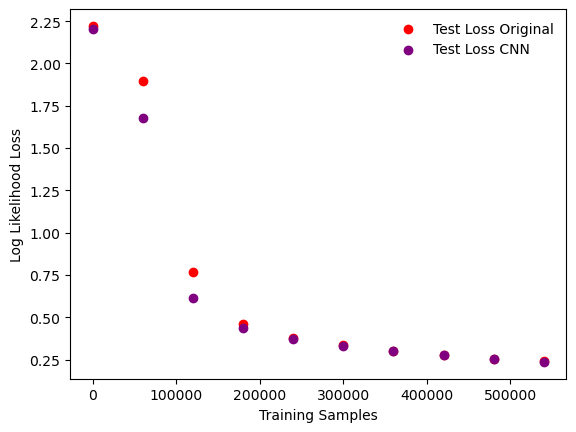

In [62]:
fig = pl.figure()
pl.scatter(test_counter[:-1], test_losses, color="red")
pl.scatter(test_counter_cnn[:-1], test_losses_cnn, color="purple")

pl.legend(['Test Loss Original', 'Test Loss CNN'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

We can see in the graph above that the loss of the CNN model is still worse than our original model, indicating that additional optimization is required to yield best performance.